In [6]:
import sys
import sklearn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline


Using TensorFlow backend.


Training Data: (60000, 28, 28)
Training Labels: (60000,)
Training Data: (10000, 28, 28)
Training Labels: (10000,)


/Users/aymericschneider/opt/anaconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


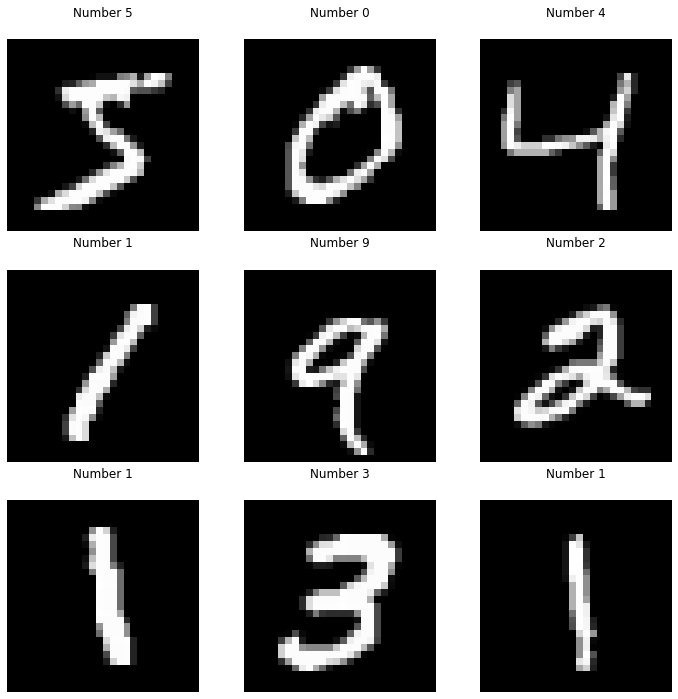

In [7]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

#Training Data: (60000L, 28L, 28L)
#Training Labels: (60000L,)

print('Training Data: {}'.format(x_test.shape))
print('Training Labels: {}'.format(y_test.shape))

#Testing Data: (10000L, 28L, 28L)
#Testing Labels: (10000L,)

# EDA

fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))

fig.show()

In [8]:
# convert each image to 1 dimensional array

X = x_train.reshape(len(x_train),-1)
Y = y_train

# normalize the data to 0 - 1

X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

#(60000L, 784L)
#(784L,)

(60000, 784)
(784,)


## 1. KMeans

### Nombre de Clusters

In [4]:
from sklearn.cluster import KMeans

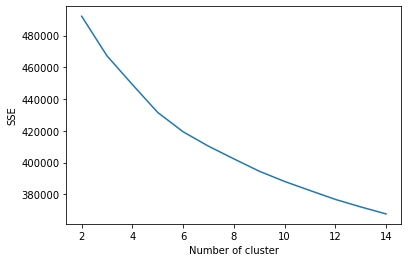

In [8]:

import matplotlib.pyplot as plt

sse = {}

for k in range(2, 15):

    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X[:10000])

    #data["clusters"] = kmeans.labels_

    #print(data["clusters"])

    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()

plt.plot(list(sse.keys()), list(sse.values()))

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

### Affichage des représentants pour n_clusters = 6

18.60331630706787


/Users/aymericschneider/opt/anaconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


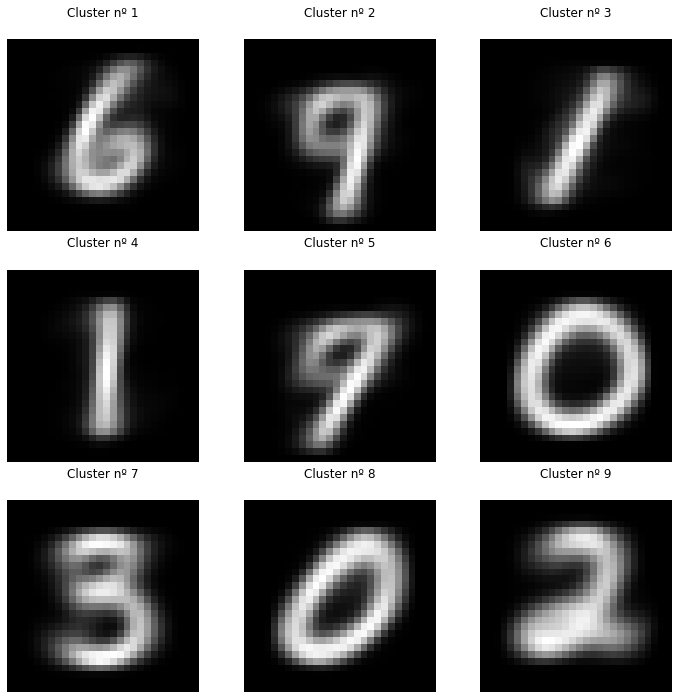

In [25]:
begin = time.time()
kmeans = KMeans(n_clusters = 12, max_iter=1000).fit(X[:40000])
end = time.time()
print(end-begin)

clusters = kmeans.cluster_centers_

fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(clusters[i].reshape((28, -1)))
    ax.axis('off')
    ax.set_title('Cluster nº %d' % (i + 1))

fig.show()

## Dendrogramme

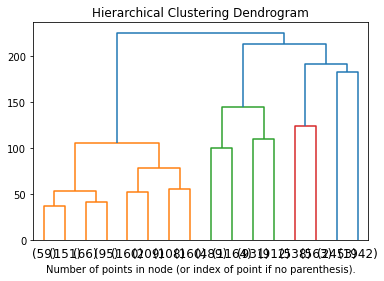

In [7]:

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X[:10000])
plt.title('Hierarchical Clustering Dendrogram')

# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



## KMedoids

In [2]:
from sklearn_extra.cluster import KMedoids
import time

In [27]:
begin = time.time()
kmeans = KMedoids(n_clusters = 12, max_iter=1000).fit(X[:20000])
end = time.time()
print(end-begin)


clusters = kmeans.cluster_centers_

fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(clusters[i].reshape((28, -1)))
    ax.axis('off')
    ax.set_title('Cluster nº %d' % (i + 1))

fig.show()

KeyboardInterrupt: 

## Kmedoids SSE Curve

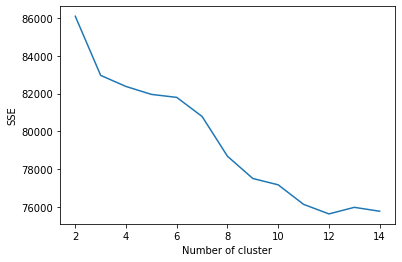

In [13]:
import matplotlib.pyplot as plt

sse = {}

for k in range(2, 15):

    kmed = KMedoids(n_clusters=k, max_iter=1000).fit(X[:10000])

    #data["clusters"] = kmeans.labels_

    #print(data["clusters"])

    sse[k] = kmed.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()

plt.plot(list(sse.keys()), list(sse.values()))

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

# Quality tools

In [11]:
def d2(x,y) : 
    return np.sum((x-y)**2)
    

def inter_cluster_inertia(X, clusters) :
    mean = np.mean(X)
    cluster_size = np.zeros(shape=clusters.shape[0])
    for point in X:
        imin = point_belongs(point, clusters)
        cluster_size[imin] += 1    
    res = 0
    for i in range(clusters.shape[0]):
        res += cluster_size[i] * d2(mean, clusters[i])
        
    return res

def point_belongs(point, clusters):
    imin = 0
    dmin = d2(point, clusters[0])
    i = 0
    for cluster in clusters:
        d = d2(point, cluster)
        if( dmin > d )  :
            dmin = d
            imin = i
        i += 1
    return imin

def cluster_guesser(X, Y, clusters):
    population = np.zeros(shape=(clusters.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        icluster = point_belongs(X[i], clusters)
        population[icluster][Y[i]] += 1
    
    guess = np.zeros(shape=clusters.shape[0])
    for i in range(clusters.shape[0]):
        jmax = 0
        nmax = 0
        for j in range(Y.shape[0]):
            if(population[i][j] > nmax):
                nmax = population[i][j]
                jmax = j
        guess[i] = jmax
    return guess

def cluster_guesser_nearest(X, Y, clusters):
    guess = np.zeros(shape=clusters.shape[0])
    c = 0
    for cluster in clusters:
        imin = 0
        dmin = d2(cluster, X[0])
        for i in range(X.shape[0]):
            if(d2(X[i], cluster) < dmin):
                imin = i
                dmin = d2(X[i], cluster)
        guess[c] = Y[imin]
        c +=1
    return guess
    
def accuracy(X, Y, clusters, guess):
    true_pos = 0
    for i in range(X.shape[0]):
        x_cluster = point_belongs(X[i], clusters)
        if(Y[i] == guess[x_cluster]):
            true_pos += 1
    return true_pos / X.shape[0]

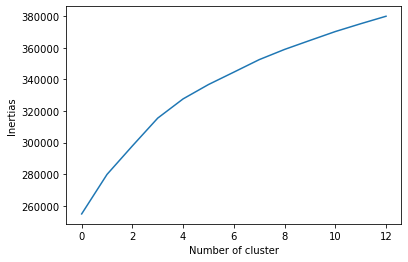

In [64]:
'''
quality = np.zeros(shape=(15-2))
print(quality.shape)

for k in range(2, 15):

    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X[:10000])

    #data["clusters"] = kmeans.labels_

    #print(data["clusters"])
    #quality[k-2][0] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    quality[k-2] = inter_cluster_inertia(X[:10000], kmeans.cluster_centers_)
    print(quality[k-2])

'''
plt.figure()

plt.plot(range(15-2), quality)

plt.xlabel("Number of cluster")

plt.ylabel("Inertias")

plt.show()

### Guesser tester

In [9]:
begin = time.time()
kmeans = KMeans(n_clusters = 12, max_iter=1000).fit(X)
end = time.time()
print(end-begin)

clusters = kmeans.cluster_centers_

guess_nearest = cluster_guesser_nearest(X, Y, clusters)
guess = cluster_guesser(X, Y, clusters)
    
print(guess)
print(guess_nearest)
acc1 = accuracy(XT,YT, clusters, guess)
acc2 = accuracy(XT,YT, clusters, guess)
print(acc1)
print(acc2)

#print(accuracy(X,Y, clusters, guess))
fig, axs = plt.subplots(4, 3, figsize = (12, 12))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(clusters[i].reshape((28, -1)))
    ax.axis('off')
    ax.set_title('Cluster nº %d' % (i + 1))

fig.show()

28.51615309715271


NameError: name 'cluster_guesser_nearest' is not defined

[0. 1.]
[0. 4.]
0.2086 0.2086
[7. 1. 0.]
[9. 1. 0.]
0.2951 0.2951
[0. 7. 3. 1.]
[0. 9. 3. 1.]
0.3788 0.3788
[7. 3. 1. 6. 0.]
[9. 3. 1. 6. 0.]
0.453 0.453
[3. 4. 1. 6. 7. 0.]
[3. 9. 1. 6. 9. 0.]
0.4778 0.4778
[3. 6. 2. 4. 0. 7. 1.]
[3. 6. 2. 9. 0. 7. 1.]
0.5304 0.5304
[2. 7. 3. 1. 6. 4. 0. 8.]
[2. 7. 3. 1. 6. 9. 0. 8.]
0.5661 0.5661
[8. 6. 0. 4. 7. 2. 1. 3. 1.]
[8. 6. 0. 9. 7. 2. 1. 3. 1.]
0.5637 0.5637
[7. 0. 2. 1. 6. 7. 8. 4. 1. 3.]
[7. 0. 2. 1. 6. 7. 8. 9. 1. 3.]
0.5646 0.5646
[1. 7. 0. 4. 3. 8. 1. 6. 2. 0. 7.]
[1. 7. 0. 9. 3. 8. 1. 6. 2. 0. 7.]
0.5805 0.5805
[7. 4. 1. 6. 1. 0. 2. 3. 5. 0. 8. 7.]
[7. 9. 1. 6. 1. 0. 2. 3. 5. 0. 8. 7.]
0.6064 0.6064
[2. 6. 4. 3. 9. 1. 0. 8. 7. 0. 5. 6. 1.]
[2. 6. 9. 3. 9. 1. 0. 8. 7. 0. 7. 6. 1.]
0.6521 0.6521
[9. 1. 4. 6. 0. 2. 5. 4. 8. 0. 7. 1. 3. 6.]
[9. 1. 9. 6. 0. 2. 5. 9. 8. 0. 7. 1. 3. 6.]
0.6521 0.6521


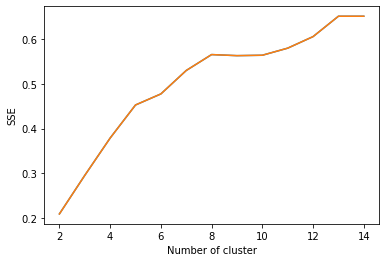

In [14]:
sse = {}
XT = x_test.reshape(len(x_test),-1)
YT = y_test

# normalize the data to 0 - 1

XT = XT.astype(float) / 255.

for k in range(2, 15):

    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X[:10000])

    #data["clusters"] = kmeans.labels_

    #print(data["clusters"])
    clusters = kmeans.cluster_centers_
    
    guess_nearest = cluster_guesser_nearest(X[:10000], Y[:10000], clusters)
    guess = cluster_guesser(X[:10000], Y[:10000], clusters)
    
    print(guess)
    print(guess_nearest)
    acc1 = accuracy(XT,YT, clusters, guess)
    acc2 = accuracy(XT,YT, clusters, guess)
    
    print(acc1, acc2)
    sse[k] = (acc1, acc2) # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()

plt.plot(list(sse.keys()), list(sse.values()))

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

# 